In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from tabulate import tabulate

# raw data

In [2]:
datapoints = pd.read_csv("mossbauer-mode-peaks-0123.csv",header=19)
counts = datapoints['Counts'].tolist()
channels = datapoints['Channel'].tolist()

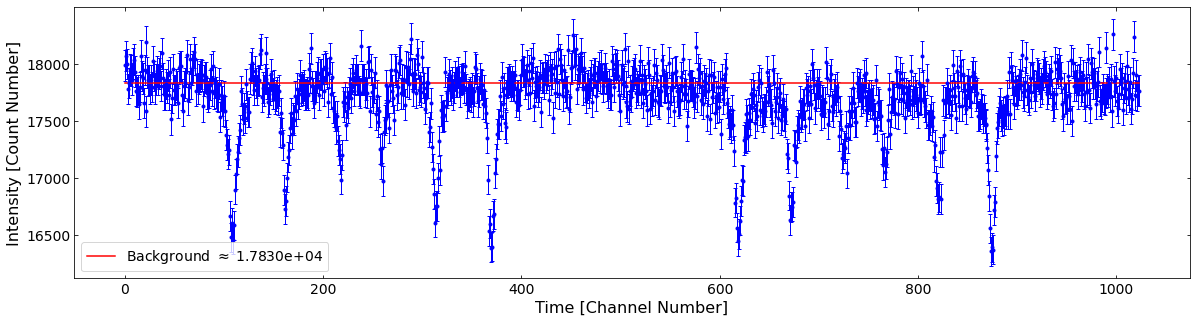

In [3]:
background_counts = np.mean(counts[0:60]+counts[420:570]+counts[930:])
plt.figure(figsize=(20,5))
plt.errorbar(channels, counts, yerr=np.sqrt(counts), fmt='.b', ecolor='b', elinewidth = 1, capsize=2) # poisson error
plt.plot(channels, [background_counts]*len(channels), '-r', label = 'Background '+ r'$\approx$ '+'{:.4e}'.format(background_counts))
plt.ylabel('Intensity [Count Number]', fontsize=16)
plt.xlabel('Time [Channel Number]', fontsize=16)
#plt.grid()
plt.xticks(fontsize=14) #np.arange(0,1023,30),
plt.yticks(fontsize=14)
plt.tick_params(bottom=True, top=True, left=True, right=True, direction="in")
plt.legend(fontsize=14)
plt.show()

In [4]:
peak_test_l, peak_test_r = [], []
for i in range(90, 390, 50):
    peak_test_l.append(np.argmin(counts[i:i+50])+i)
for i in range(600, 900, 50):
    peak_test_r.append(np.argmin(counts[i:i+50])+i)
peak_test = peak_test_l+peak_test_r

# calibration

In [5]:
max_velocity_channel = []
for i in range(0,6,1):
    max_velocity_channel.append((peak_test[i]+peak_test[11-i])/2)
mid_point = np.mean(max_velocity_channel)

In [6]:
# velocity in unit of mini meter per second [mm/s]
# energy in unit of electron volt [eV]
velocity_channels=[]
energy_channels=[]
for x in channels:
    velocity_channels.append(10.22-abs(x-500)*(10.22+9.59)/499)
for v in velocity_channels:
    energy_channels.append(v*14.4/(299792458))

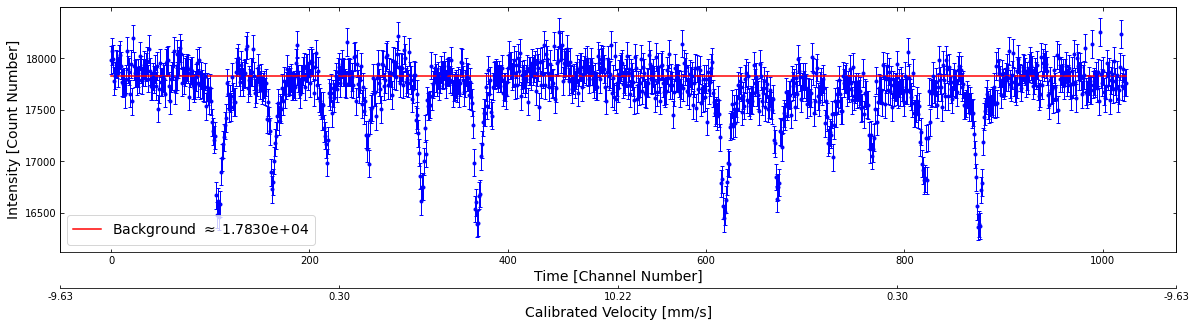

In [7]:
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

# Add some extra space for the second axis at the bottom
fig.subplots_adjust(bottom=0.2)

ax1.errorbar(channels, counts, yerr=np.sqrt(counts), fmt='.b', ecolor='b', elinewidth = 1, capsize=2) # poisson error
ax1.plot(channels, [background_counts]*len(channels), '-r', label = 'Background '+ r'$\approx$ '+'{:.4e}'.format(background_counts))
ax1.set_ylabel('Intensity [Count Number]', fontsize=14)
ax1.set_xlabel('Time [Channel Number]', fontsize=14)

# Move twinned axis ticks and label from top to bottom
ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_label_position("bottom")
# Offset the twin axis below the host
ax2.spines["bottom"].set_position(("axes", -0.15))

ax2.set_frame_on(True)
ax2.patch.set_visible(False)

new_tick_locations = np.array([0, 250, 500, 750, 1000])

def tick_function(x):
    v = 10.22-abs(x-500)*(10.22+9.59)/499
    return ["%.2f" % z for z in v]
#ax2.set_xticks()
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations))
ax2.set_xlabel(r"Calibrated Velocity [mm/s]", fontsize=14)
#plt.grid()
# plt.xticks(fontsize=14) #np.arange(0,1023,30),
# ax1.set_yticks(fontsize=14)
ax1.tick_params(bottom=True, top=True, left=True, right=True, direction="in")
ax2.tick_params(bottom=True, top=True, left=True, right=True, direction="in")
ax1.legend(fontsize=14)
plt.show()

# Gaussian fit

In [8]:
def gaussian_test_half(x, bg, mu0, mu1, mu2, mu3, mu4, mu5, sigma0, 
                       sigma1, sigma2, sigma3, sigma4, sigma5, amp0, amp1, amp2, amp3, amp4, amp5):
    return bg+amp0*np.exp(((x-mu0)/sigma0)**2 /(-2))/((2*np.pi)**(0.5)*sigma0) \
            +amp1*np.exp(((x-mu1)/sigma1)**2 /(-2))/((2*np.pi)**(0.5)*sigma1) \
            +amp2*np.exp(((x-mu2)/sigma2)**2 /(-2))/((2*np.pi)**(0.5)*sigma2) \
            +amp3*np.exp(((x-mu3)/sigma3)**2 /(-2))/((2*np.pi)**(0.5)*sigma3) \
            +amp4*np.exp(((x-mu4)/sigma4)**2 /(-2))/((2*np.pi)**(0.5)*sigma4) \
            +amp5*np.exp(((x-mu5)/sigma5)**2 /(-2))/((2*np.pi)**(0.5)*sigma5)

In [9]:
def gaussian_fit_half(channels = channels[492:992], counts = counts[492:992], peak_channels = peak_test_r, 
                      background_test = background_counts, without_background = False, both_fit = False, x_label = 'Time [Channel Number]'):
    # initialize
    plt.figure(figsize=(15,5))
    mean_list = []
    sdeviation_list = []
    amp_list = []
    background_noise = background_test
    
    # iterate around each peak
    for i_peak in peak_channels:
        # initialize
        if i_peak > 500:
            i_peak = i_peak - 492
        xdata = np.array(channels[i_peak-14:i_peak+14])
        ydata = np.array(counts[i_peak-14:i_peak+14])
        mean = sum(xdata * ydata) / sum(ydata)
        sdeviation = np.sqrt(sum(ydata * (xdata - mean)**2) / sum(ydata))
        amplitude = min(ydata)-background_noise
        
        # record test parameters
        mean_list.append(mean)
        sdeviation_list.append(sdeviation)
        amp_list.append(amplitude)
    
    #plt.plot(channels, [background_noise]*len(channels), '-k', label = 'Background '+ r'$\approx$ '+'{:.4e}'.format(background_noise))
    
    # remove background noise
    fit_label = 'Gaussian fit, with background'
    fit_counts = counts.copy()
    fit_channels = channels.copy()
    if without_background:
        pop_index = len(fit_counts)
        while pop_index > 0:
            pop_index = pop_index - 1
            if fit_counts[pop_index] > background_noise:
                fit_counts.pop(pop_index)
                fit_channels.pop(pop_index)
        fit_label = 'Gaussain fit, without background'
        
    # curve fit
    popt, pcov = curve_fit(gaussian_test_half, np.array(fit_channels), np.array(fit_counts), \
                    p0=[background_noise, *mean_list, *sdeviation_list, *amp_list], maxfev=10000)
    
    
    # plot
    # squareroot error for counts
    plt.errorbar(channels, counts, yerr = np.sqrt(counts), fmt='.b', ecolor='b', elinewidth = 1, capsize=2)

    
    if both_fit:
        popt1, pcov1 = curve_fit(gaussian_test_half, np.array(channels), np.array(counts), \
                        p0=[background_noise, *mean_list, *sdeviation_list, *amp_list], maxfev=10000)
        plt.plot(channels, gaussian_test_half(channels, *popt1), color='k', label = 'Gaussian fit, with background')
        
    plt.plot(channels, gaussian_test_half(channels, *popt), color='r', label = fit_label)
    
    plt.ylabel('Intensity [Count Number]', fontsize=14)
    plt.xlabel(x_label, fontsize=14)
    plt.xticks(fontsize=14) #popt[1:7]
    plt.yticks(fontsize=14)
    plt.tick_params(bottom=True, top=True, left=True, right=True, direction="in")
    plt.legend(fontsize=14)
    plt.show()
    return popt

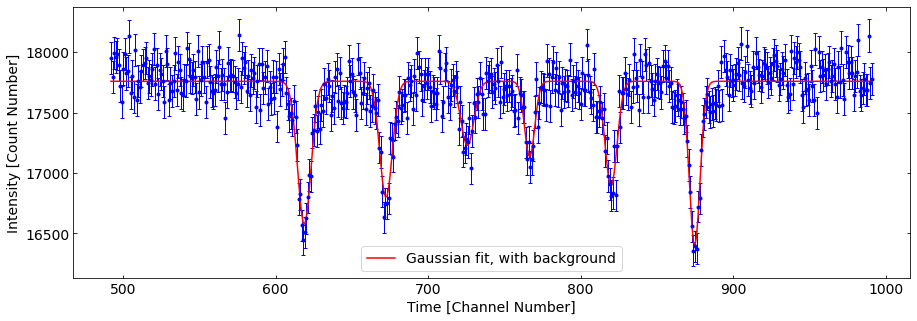

  Mean [Channels]    Standard Deviation [Channels]    Amplitude[Counts]
-----------------  -------------------------------  -------------------
          618.761                          4.4298             -13152.6
          672.353                          4.14269            -10006.9
          725.736                          4.29233             -5714.83
          766.563                          3.33164             -5225.44
          819.955                          3.92052             -8520.42
          874.779                          3.51333            -11993.2


In [10]:
gaussian_fit_half_r=gaussian_fit_half()
print(tabulate({'Mean [Channels]':gaussian_fit_half_r[1:7],'Standard Deviation [Channels]':gaussian_fit_half_r[7:13],'Amplitude[Counts]':gaussian_fit_half_r[13:19]}, headers='keys'))

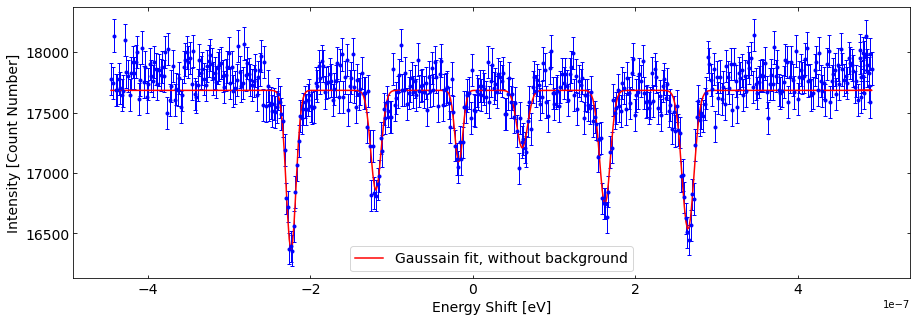

   Mean [eV]    Standard Deviation [eV]    Amplitude[Counts]
------------  -------------------------  -------------------
 2.64576e-07                7.44547e-09         -2.15087e-05
 1.62441e-07                6.59052e-09         -1.55941e-05
 6.06459e-08                6.65531e-09         -7.96711e-06
-1.74354e-08                4.90985e-09         -7.37542e-06
-1.19409e-07                6.39312e-09         -1.32594e-05
-2.23792e-07                6.03452e-09         -2.00558e-05


In [11]:
gaussian_fit_half_r_energy=gaussian_fit_half(energy_channels[492:992], peak_channels = peak_test_r, without_background=True, x_label = 'Energy Shift [eV]')
print(tabulate({'Mean [eV]':gaussian_fit_half_r_energy[1:7],'Standard Deviation [eV]':gaussian_fit_half_r_energy[7:13],'Amplitude[Counts]':gaussian_fit_half_r_energy[13:19]}, headers='keys'))

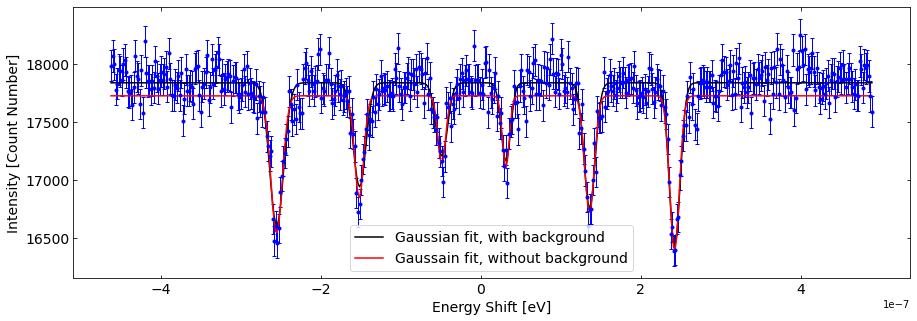

   Mean [eV]    Standard Deviation [eV]    Amplitude[Counts]
------------  -------------------------  -------------------
-2.5546e-07                 7.25672e-09         -2.14659e-05
-1.52159e-07                5.70546e-09         -1.25392e-05
-4.88677e-08                4.91007e-09         -7.21061e-06
 3.12669e-08                4.30211e-09         -6.65309e-06
 1.35871e-07                6.06749e-09         -1.52095e-05
 2.42227e-07                6.08498e-09         -2.02773e-05


In [12]:
gaussian_fit_half_l_energy=gaussian_fit_half(energy_channels[0:500], counts[0:500], peak_channels = peak_test_l, without_background=True,both_fit=True, x_label = 'Energy Shift [eV]')
print(tabulate({'Mean [eV]':gaussian_fit_half_l_energy[1:7],'Standard Deviation [eV]':gaussian_fit_half_l_energy[7:13],'Amplitude[Counts]':gaussian_fit_half_l_energy[13:19]}, headers='keys'))

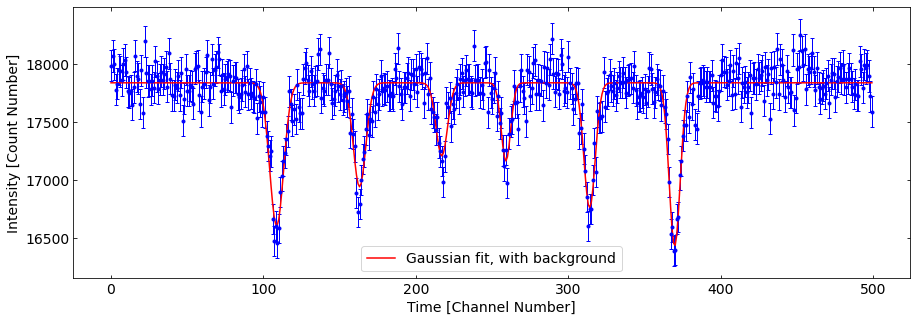

  Mean [Channels]    Standard Deviation [Channels]    Amplitude[Counts]
-----------------  -------------------------------  -------------------
          108.646                          4.5709             -14066.6
          162.993                          4.11442             -9217.54
          216.929                          3.76684             -5934.04
          258.988                          3.09266             -5205.96
          313.871                          3.70718             -9992.4
          369.655                          3.60777            -12691.4


In [13]:
gaussian_fit_half_l=gaussian_fit_half(channels[0:500], counts[0:500], peak_channels = peak_test_l, without_background = False)
print(tabulate({'Mean [Channels]':gaussian_fit_half_l[1:7],'Standard Deviation [Channels]':gaussian_fit_half_l[7:13],'Amplitude[Counts]':gaussian_fit_half_l[13:19]}, headers='keys'))

# Lorentzian fit

In [14]:
def lorentzian_test_half(x, bg, mu0, mu1, mu2, mu3, mu4, mu5, 
                         gamma0, gamma1, gamma2, gamma3, gamma4, gamma5, amp0, amp1, amp2, amp3, amp4, amp5):
    return bg + (amp0 / np.pi) * (gamma0 / 2) / ((x - mu0)**2 + (gamma0 / 2)**2) \
            + (amp1 / np.pi) * (gamma1 / 2) / ((x - mu1)**2 + (gamma1 / 2)**2) \
            + (amp2 / np.pi) * (gamma2 / 2) / ((x - mu2)**2 + (gamma2 / 2)**2) \
            + (amp3 / np.pi) * (gamma3 / 2) / ((x - mu3)**2 + (gamma3 / 2)**2) \
            + (amp4 / np.pi) * (gamma4 / 2) / ((x - mu4)**2 + (gamma4 / 2)**2) \
            + (amp5 / np.pi) * (gamma5 / 2) / ((x - mu5)**2 + (gamma5 / 2)**2)

In [15]:
def lorentzian_fit_half(channels = channels[492:992], counts = counts[492:992], peak_channels = peak_test_r, 
                      background_test = background_counts, without_background = False, both_fit = False, x_label = 'Time [Channel Number]'):
    # initialize
    plt.figure(figsize=(15,5))
    mean_list = []
    sdeviation_list = []
    amp_list = []
    background_noise = background_test
    
    # iterate around each peak
    for i_peak in peak_channels:
        # initialize
        if i_peak > 500:
            i_peak = i_peak - 492
        xdata = np.array(channels[i_peak-14:i_peak+14])
        ydata = np.array(counts[i_peak-14:i_peak+14])
        mean = sum(xdata * ydata) / sum(ydata)
        sdeviation = 2*np.sqrt(sum(ydata * (xdata - mean)**2) / sum(ydata))
        amplitude = min(ydata)-background_noise
        
        # record test parameters
        mean_list.append(mean)
        sdeviation_list.append(sdeviation)
        amp_list.append(amplitude)
    
    #plt.plot(channels, [background_noise]*len(channels), '-k', label = 'Background '+ r'$\approx$ '+'{:.4e}'.format(background_noise))
    
    # remove background noise
    fit_label = 'Lorentzian fit, with background'
    fit_counts = counts.copy()
    fit_channels = channels.copy()
    if without_background:
        pop_index = len(fit_counts)
        while pop_index > 0:
            pop_index = pop_index - 1
            if fit_counts[pop_index] > background_noise:
                fit_counts.pop(pop_index)
                fit_channels.pop(pop_index)
        fit_label = 'Lorentzian fit, without background'
        
    # curve fit
    popt, pcov = curve_fit(lorentzian_test_half, np.array(fit_channels), np.array(fit_counts), \
                    p0=[background_noise, *mean_list, *sdeviation_list, *amp_list], maxfev=10000)

    # plot
    # squareroot error for counts
    plt.errorbar(channels, counts, yerr = np.sqrt(counts), fmt='.b', ecolor='b', elinewidth = 1, capsize=2)
    
    if both_fit:
        popt1, pcov1 = curve_fit(lorentzian_test_half, np.array(channels), np.array(counts), \
                        p0=[background_noise, *mean_list, *sdeviation_list, *amp_list], maxfev=10000)
        plt.plot(channels, lorentzian_test_half(channels, *popt1), color='k', label = 'Lorentzian fit, with background')
    plt.plot(channels, lorentzian_test_half(channels, *popt), color='r', label = fit_label)        

    
    plt.ylabel('Intensity [Count Number]', fontsize=14)
    plt.xlabel(x_label, fontsize=14)
    plt.xticks(fontsize=14) #popt[1:7]
    plt.yticks(fontsize=14)
    plt.tick_params(bottom=True, top=True, left=True, right=True, direction="in")
    plt.legend(fontsize=14)
    plt.show()
    return popt

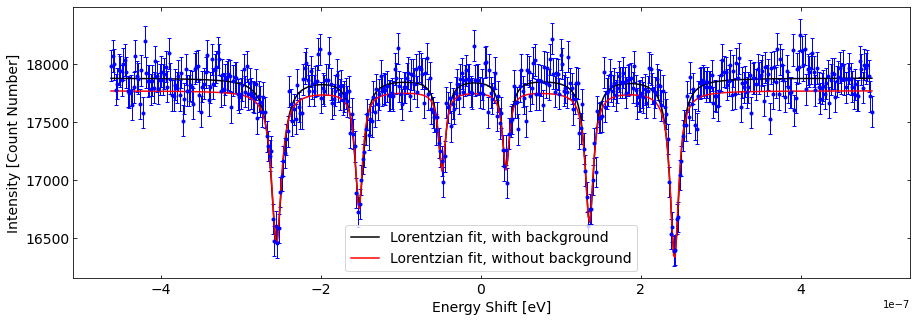

   Mean [eV]    Half-Width [eV]    Amplitude[Counts]
------------  -----------------  -------------------
-2.556e-07          1.44072e-08         -3.00882e-05
-1.52405e-07        1.08448e-08         -1.73976e-05
-4.83939e-08        9.98709e-09         -1.07635e-05
 3.13868e-08        9.78701e-09         -1.03569e-05
 1.35683e-07        1.20704e-08         -2.14789e-05
 2.42117e-07        1.24258e-08         -2.83729e-05


In [16]:
lorentzian_fit_half_l_energy=lorentzian_fit_half(energy_channels[0:500], counts[0:500], peak_channels = peak_test_l, without_background=True, both_fit=True, x_label = 'Energy Shift [eV]')
print(tabulate({'Mean [eV]':lorentzian_fit_half_l_energy[1:7],'Half-Width [eV]':lorentzian_fit_half_l_energy[7:13],'Amplitude[Counts]':lorentzian_fit_half_l_energy[13:19]}, headers='keys'))

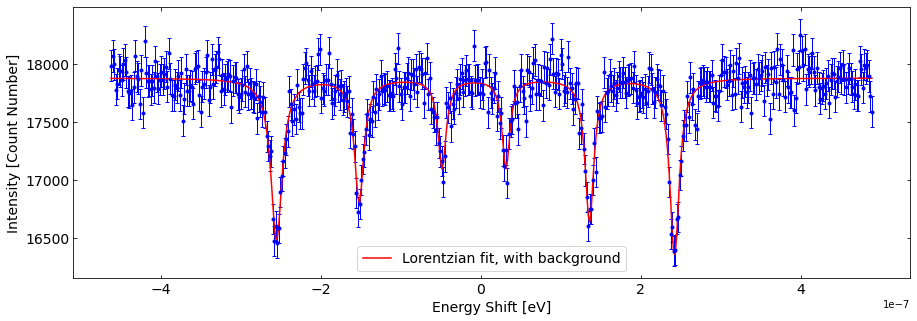

   Mean [eV]    Half-Width [eV]    Amplitude[Counts]
------------  -----------------  -------------------
-2.55563e-07        1.69707e-08         -3.72565e-05
-1.52167e-07        1.42888e-08         -2.37956e-05
-4.8491e-08         1.23815e-08         -1.49543e-05
 3.14361e-08        1.18067e-08         -1.42388e-05
 1.35796e-07        1.32766e-08         -2.57147e-05
 2.42202e-07        1.42593e-08         -3.4311e-05


In [17]:
lorentzian_fit_half_l_energy=lorentzian_fit_half(energy_channels[0:500], counts[0:500], peak_channels = peak_test_l, without_background=False, both_fit=False, x_label = 'Energy Shift [eV]')
print(tabulate({'Mean [eV]':lorentzian_fit_half_l_energy[1:7],'Half-Width [eV]':lorentzian_fit_half_l_energy[7:13],'Amplitude[Counts]':lorentzian_fit_half_l_energy[13:19]}, headers='keys'))

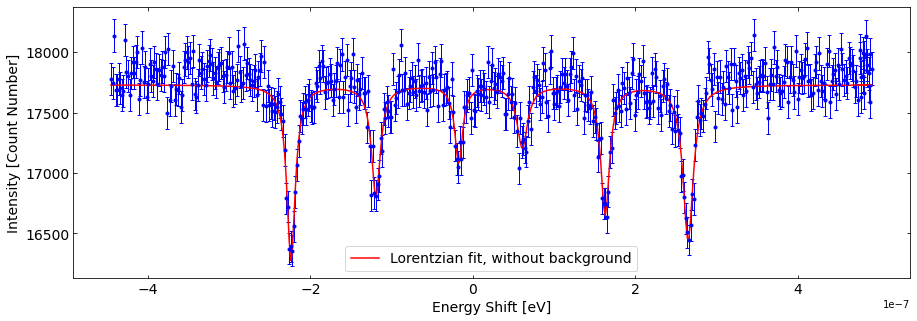

   Mean [eV]    Half-Width [eV]    Amplitude[Counts]
------------  -----------------  -------------------
 2.64775e-07        1.5381e-08          -3.10046e-05
 1.62716e-07        1.31392e-08         -2.21168e-05
 6.07592e-08        1.57232e-08         -1.27368e-05
-1.7497e-08         1.15005e-08         -1.16912e-05
-1.19346e-07        1.32831e-08         -1.92337e-05
-2.23839e-07        1.25725e-08         -2.87283e-05


In [18]:
lorentzian_fit_half_r_energy=lorentzian_fit_half(energy_channels[492:992], counts[492:992], peak_channels = peak_test_r, without_background=True, x_label = 'Energy Shift [eV]')
print(tabulate({'Mean [eV]':lorentzian_fit_half_r_energy[1:7],'Half-Width [eV]':lorentzian_fit_half_r_energy[7:13],'Amplitude[Counts]':lorentzian_fit_half_r_energy[13:19]}, headers='keys'))

In [25]:
lorentzian_fit_half_l_energy[1:7]

array([-2.55562654e-07, -1.52166752e-07, -4.84910458e-08,  3.14360705e-08,
        1.35795839e-07,  2.42201998e-07])

In [24]:
lorentzian_fit_half_r_energy[1:7]

array([ 2.64774515e-07,  1.62716290e-07,  6.07592418e-08, -1.74969585e-08,
       -1.19346372e-07, -2.23838744e-07])

In [89]:
energy_fit_peaks = []
energy_fit_width = []
for i in range(0,6):
    energy_fit_peaks.append((lorentzian_fit_half_l_energy[i+1]+lorentzian_fit_half_r_energy[6-i])/2)
    energy_fit_width.append(np.sqrt(lorentzian_fit_half_l_energy[i+7]**2+lorentzian_fit_half_r_energy[12-i]**2)/2)
#mid_point = np.mean(energy_fit_peaks)

In [90]:
energy_fit_peaks
energy_fit_width

[1.0560232542633441e-08,
 9.754602637050274e-09,
 8.449289236920702e-09,
 9.831278322760526e-09,
 9.339526519818494e-09,
 1.048690053259201e-08]

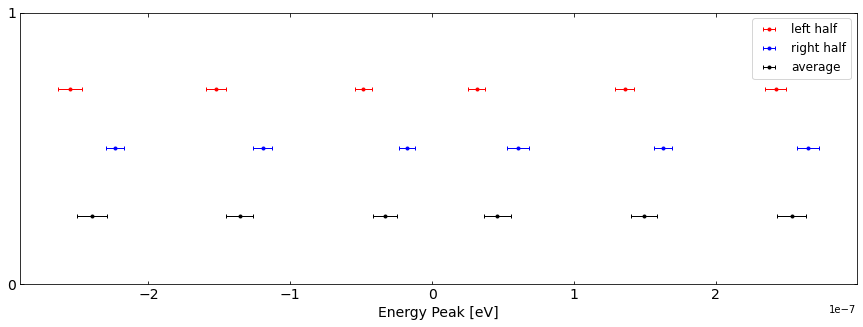

In [103]:
plt.figure(figsize=(15,5))
plt.errorbar(lorentzian_fit_half_l_energy[1:7], [0.72]*6, xerr=lorentzian_fit_half_l_energy[7:13]/2, fmt='.r', ecolor='r', elinewidth = 1, capsize=2, label='left half')
plt.errorbar(lorentzian_fit_half_r_energy[1:7], [0.5]*6, xerr=lorentzian_fit_half_r_energy[7:13]/2, fmt='.b', ecolor='b', elinewidth = 1, capsize=2, label = 'right half')
plt.errorbar(energy_fit_peaks, [0.25]*6, xerr=energy_fit_width, fmt='.k', ecolor='k', elinewidth = 1, capsize=2, label = 'average')
#plt.ylabel('', fontsize=14)
plt.xlabel('Energy Peak [eV]', fontsize=14)
plt.xticks(fontsize=14) #popt[1:7]
plt.yticks([0,1],fontsize=14)
plt.tick_params(bottom=True, top=True, left=True, right=True, direction="in")
plt.legend(fontsize=12)
plt.show()

In [105]:
mu_moment_nuc = -3.152451*10**(-12)
mu_moment_ground = 0.0964*mu_moment_nuc
mu_moment_1st = -0.1553*mu_moment_nuc
H_mag = []
H_mag.append(energy_fit_peaks[0]/(mu_moment_ground-mu_moment_1st))
H_mag.append(energy_fit_peaks[1]/(mu_moment_ground-mu_moment_1st*(1/3)))
H_mag.append(energy_fit_peaks[2]/(mu_moment_ground-mu_moment_1st*(-1/3)))
H_mag.append(energy_fit_peaks[3]/(mu_moment_ground*(-1)-mu_moment_1st*(1/3)))
H_mag.append(energy_fit_peaks[4]/(mu_moment_ground*(-1)-mu_moment_1st*(-1/3)))
H_mag.append(energy_fit_peaks[5]/(mu_moment_ground*(-1)-mu_moment_1st*(-1)))

In [114]:
H_mag_err = []
H_mag_err.append(energy_fit_width[0]/(mu_moment_ground-mu_moment_1st))
H_mag_err.append(energy_fit_width[1]/(mu_moment_ground-mu_moment_1st*(1/3)))
H_mag_err.append(energy_fit_width[2]/(mu_moment_ground-mu_moment_1st*(-1/3)))
H_mag_err.append(energy_fit_width[3]/(mu_moment_ground*(-1)-mu_moment_1st*(1/3)))
H_mag_err.append(energy_fit_width[4]/(mu_moment_ground*(-1)-mu_moment_1st*(-1/3)))
H_mag_err.append(energy_fit_width[5]/(mu_moment_ground*(-1)-mu_moment_1st*(-1)))

In [113]:
for i in range(6):
    print(energy_fit_width[i]/energy_fit_peaks[i])

-0.04405591047244417
-0.07185363649623423
-0.2560856123317438
0.2132706766766764
0.06257384943480143
0.04137036037206995


In [110]:
np.mean(H_mag)

298976.7668641598

In [119]:
np.mean(H_mag_err)
mag_err=0
for i in range(6):
    mag_err = np.sqrt(mag_err**2+H_mag_err[i]**2)
print(mag_err/np.sqrt(6))

40157.64191499937


In [111]:
print(tabulate({'Mean [eV]':energy_fit_peaks,'Half-Width/2 [eV]':energy_fit_width,'Magnetic Field [Gauss]':H_mag}, headers='keys'))

   Mean [eV]    Half-Width/2 [eV]    Magnetic Field [Gauss]
------------  -------------------  ------------------------
-2.39701e-07          1.05602e-08                    302091
-1.35757e-07          9.7546e-09                     290644
-3.2994e-08           8.44929e-09                    234492
 4.60977e-08          9.83128e-09                    327621
 1.49256e-07          9.33953e-09                    319546
 2.53488e-07          1.04869e-08                    319467


In [61]:
lorentzian_fit_half_l_energy[1:7]

array([-2.55562654e-07, -1.52166752e-07, -4.84910458e-08,  3.14360705e-08,
        1.35795839e-07,  2.42201998e-07])